# The Thermal Expansion of MgO - Molecular Dynamics

Finally, we are going to calculate the volume of the MgO crystal, at different temperatures, by using molecular dynamics. <br>

Molecular Dynamics is a technique for allowing a system to evolve in time according to Newton's second law. The atoms simply follow the trajectories that they would in reality and we can then compute properties as time averages of their behaviour.<br>

First of all an initial configuration and initial velocities need to be assigned - here the initial configuration will be that of ideal MgO and the velocities will be random but scaled to produce roughly the target temperature.<br>

MD computes the final volume at the requested temperature by using the Verlet algorithm:<br>
    - Compute the forces on the atoms (F).
    - Compute the accelerations a=F/m
    - Update the velocities: Vnew = Vold + a * dt
    - Update the positions of the atoms: Rnew = Rold + Vnew * dt
    - Repeat until average properties like E and T settle down
    - Once settled measure some properties.

First, run the calculation for T=100K, a window will open to show you the cell used for this calculation. Then animate the motion of the atoms by using the cell below.<br>

Increase the T from 100K in 100K intervals. As in the previous exercise you can do so by manually changing the T value in the input below, or you can write a for loop that will do that for you.


<br><br>

In [2]:
#the imports first, always
import numpy as np
import re
import os
from ase.build import make_supercell
from ase.io import Trajectory
from ase.build import cut
from os import remove
from ase.spacegroup import crystal
from ase.visualize import view
from ase.calculators.gulp import GULP

#SELECT THE TEMPERATURE
T_range = np.arange(100,3100,100)
# generate the crystal starting from a geometry that is close to the optimised one
a = 4.1
#generate the conventional cell
MgO = crystal('MgO',basis=[[0.0,0.0,0.0],[0.5,0.5,0.5]],spacegroup=225,cellpar=[a, a, a, 90, 90, 90],primitive_cell=False)

#select the size of the supercell
supercell = 2
#create the supercell
MgO_SC_MD = make_supercell(MgO, supercell*np.identity(3))
#visualise the cell
view(MgO_SC_MD)

for T in T_range:

#name of the calculation
    label='mgo_SC_MD_{}'.format(T)
#select the options for the calculations
    options = ['integrator leapfrog verlet',
'ensemble npt 0.005 0.005',
'temperature {}'.format(T),
'equil 0.50 ps',
'produ 0.50 ps',
'timestep 0.001 ps',
'sample 0.005 ps',
'iterations 5 ',
'dump every 5 noover {}.grs'.format(label)]
#run the calculation
    calc = GULP(label=label,keywords='conp md', library='ionic.lib', options=options)
    MgO_SC_MD.calc = calc
    MgO_SC_MD.get_potential_energy()
#look for the optimised volume in the output
    for line in reversed(list(open(label+'.got'))):
        a = re.match(r'\s*Cell volume\s*\S+\s*\S+\s*=\s*(\S+)\s*(\S+)', line)
        if a:
            V_final = a.group(2)
            print(T, ' (K) - Optimised Volume = ', a.group(2))
            break
#write the trajectory file to show the movement of the atoms at the temperature of the simulation
traj = Trajectory('{}K.trj'.format(label), 'w')    
for t in range(1,52):
    with open('{}_{}.grs'.format(label,t)) as o:
        pos_out = o.readlines()
        new_cell = np.zeros((3, 3), dtype=float)
        new_pos = np.zeros((MgO_SC_MD.get_number_of_atoms(), 3), dtype=float)
        for i,line in enumerate(pos_out):
            m =  re.match(r'vectors', line)
            if m:
                for j in range(0,3):
                    new_cell[j] = [float(x) for x in pos_out[i+j+1].split()]
            n = re.match(r'cartesian',line)
            if n:
                for j in range(0,MgO_SC_MD.get_number_of_atoms()):
                    first = pos_out[i+j+1].split()
                    first = first[2:5]
                    new_pos[j] = [float(x) for x in pos_out[i+j+1].split()[2:5]]    
        MgO_SC_MD.set_cell(new_cell)
        MgO_SC_MD.set_positions(new_pos)
        MgO_SC_MD_out = MgO_SC_MD
        MgO_SC_MD_out = cut(MgO_SC_MD, origo=(MgO_SC_MD.get_center_of_mass(scaled=True)),extend=1.01)
        traj.write(MgO_SC_MD_out)
traj.close()
#removing the files we don't need anymore to leave the directory clean
for i in range(1,52):
    if os.path.exists('./mgo_SC_MD_{}_{}.grs'.format(T,i)):
        os.remove('./mgo_SC_MD_{}_{}.grs'.format(T,i))
    else:
        break


100  (K) - Optimised Volume =  599.395871
200  (K) - Optimised Volume =  600.717540
300  (K) - Optimised Volume =  602.519445
400  (K) - Optimised Volume =  604.131946
500  (K) - Optimised Volume =  606.349864
600  (K) - Optimised Volume =  608.202458
700  (K) - Optimised Volume =  609.868299
800  (K) - Optimised Volume =  611.745502
900  (K) - Optimised Volume =  614.053593
1000  (K) - Optimised Volume =  615.771646
1100  (K) - Optimised Volume =  616.577072
1200  (K) - Optimised Volume =  617.546364
1300  (K) - Optimised Volume =  619.299785
1400  (K) - Optimised Volume =  622.392857
1500  (K) - Optimised Volume =  625.569894
1600  (K) - Optimised Volume =  628.442520
1700  (K) - Optimised Volume =  631.385027
1800  (K) - Optimised Volume =  632.954446
1900  (K) - Optimised Volume =  634.114118
2000  (K) - Optimised Volume =  637.710825
2100  (K) - Optimised Volume =  639.965565
2200  (K) - Optimised Volume =  640.845050
2300  (K) - Optimised Volume =  643.521629
2400  (K) - Optimise

In [6]:
#use this cell to animate the motion of the atoms. You will have to change the name of the .trj file
! ase gui mgo_SC_MD_100K.trj 2> tmp

Figure(632.456x400)


**Questions**:<br>
1. How is the cell we are using here different from the previous ones?<br>
    - Why do we need a larger cell?<br>
    - Is the cell we are using large enough? Explain why <br>
    <br>
2. Replot your data from the quasi-harmonic approximation calculations as, cell volume per formula unit vs temperature, and add some points from the MD runs at a few suitable temperatures.<br>
    - How does the thermal expansion predicted by MD compare to that predicted by the quasi-harmonic approximation?<br>
    - Why do the two methods produce different answers? How does the difference depend on temperature?<br>
    
    - What would happen to the cell volume at very high temperature in MD?<br>

In [1]:
LD=[18.83646, 18.838231, 18.856162, 18.88998, 18.932453,
    18.980046, 19.031143, 19.084962, 19.141205, 19.1995,
    19.25986, 19.322305, 19.387173, 19.454059, 19.523336,
    19.595184, 19.66983, 19.747549, 19.828679, 19.913637,
    20.002943, 20.097259,20.197442, 20.304633, 20.420411,
    20.547053, 20.688043,20.851781, 21.04992, 21.319006]
LDT=[0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900]

In [2]:
MD=[599.395871, 600.717540, 602.519445,  604.131946,  606.349864,
    608.202458, 609.868299, 611.745502,  614.053593,  615.771646,
    616.577072, 617.546364, 619.299785,  622.392857,  625.569894,
    628.442520, 631.385027, 632.954446,  634.114118,  637.710825,
    639.965565, 640.845050, 643.521629,  645.379390,  646.785384,
    657.849444, 659.924701, 667.541364,  665.357700,  668.202153]
MDT=LDT=[100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]

Populating the interactive namespace from numpy and matplotlib


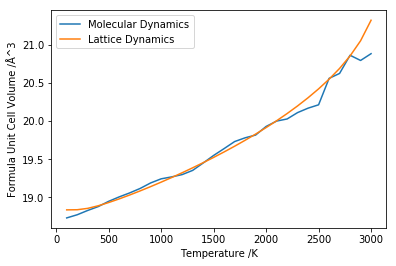

In [5]:
%pylab inline
MD1=np.array(MD)/32
plt.plot(MDT,MD1,label='Molecular Dynamics')
plt.plot(LDT,LD, label='Lattice Dynamics')
plt.xlabel('Temperature /K')
plt.ylabel('Formula Unit Cell Volume /Å^3')
plt.legend()
plt.show()